In [37]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
from IPython.display import display, HTML

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from _preprocessing import change_dtypes
from _preprocessing import aggregate
from _stats import f_ratio
from _stats import corrwith
from _stats import mode
from _stats import mean_diff, var_diff, range_diff

INP_DIR = "data/download"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. `application`

In [2]:
application_train = pd.read_csv(os.path.join(INP_DIR, "application_train.csv"))
application_train = change_dtypes(application_train)

print("application_train.shape:", application_train.shape)
application_train.head()

Memory usage before changing types 300.13 MB
Memory usage after changing types 129.78 MB
application_train.shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,True,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,False,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,False,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,False,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,False,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Missing values

In [3]:
missing_vals = application_train.isnull().mean()
missing_vals = missing_vals.sort_values(ascending=False)
print("Total number of features:", application_train.shape[1])
print("Number of features having missing values:", (missing_vals > 0).sum())

print("head:")
display(missing_vals.head(20))
print("tail")
display(missing_vals[missing_vals > 0].tail(20))

Total number of features: 122
Number of features having missing values: 67
head:


COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAPARTMENTS_AVG        0.683550
FLOORSMIN_MEDI              0.678486
FLOORSMIN_MODE              0.678486
FLOORSMIN_AVG               0.678486
YEARS_BUILD_MEDI            0.664978
YEARS_BUILD_AVG             0.664978
YEARS_BUILD_MODE            0.664978
OWN_CAR_AGE                 0.659908
LANDAREA_MODE               0.593767
LANDAREA_AVG                0.593767
LANDAREA_MEDI               0.593767
dtype: float64

tail


TOTALAREA_MODE                0.482685
EMERGENCYSTATE_MODE           0.473983
OCCUPATION_TYPE               0.313455
EXT_SOURCE_3                  0.198253
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_HOUR    0.135016
NAME_TYPE_SUITE               0.004201
OBS_30_CNT_SOCIAL_CIRCLE      0.003320
OBS_60_CNT_SOCIAL_CIRCLE      0.003320
DEF_60_CNT_SOCIAL_CIRCLE      0.003320
DEF_30_CNT_SOCIAL_CIRCLE      0.003320
EXT_SOURCE_2                  0.002146
AMT_GOODS_PRICE               0.000904
AMT_ANNUITY                   0.000039
CNT_FAM_MEMBERS               0.000007
DAYS_LAST_PHONE_CHANGE        0.000003
dtype: float64

## Categorical columns

We group the `TARGET` by a categorical feature. `TARGET` in each group is aggregated by `mean`, `var` and `count`. The resulting `group mean`, `group variance` and `group count` are used to calculate the F-ratio which is define as the `between-group variance` divided by `within-group variance`.

In [4]:
def f_ratio_df(df):
    return f_ratio(df["default_rate"], df["var_of_default_rate"], df["count"])

In [5]:
# columns of categorical type
cat_cols = application_train.select_dtypes(["category"]).columns
agg_stats = [("default_rate", "mean"), ("var_of_default_rate", np.var), "count"]

results = []
for col in cat_cols:
    df = application_train.groupby(
        application_train[col].astype(str))["TARGET"].agg(agg_stats)
    df = df.sort_values("default_rate", ascending=False)
    results.append((col, df))

# sort by the F-ratio
results = sorted(results, key=lambda x: f_ratio_df(x[1]), reverse=True)
for col, df in results:
    print("%s, f-ratio=%0.5f" % (col, f_ratio_df(df)))
    display(df)
    print("------------------------------------------\n\n")

OCCUPATION_TYPE, f-ratio=0.00646


,default_rate,var_of_default_rate,count
OCCUPATION_TYPE,,,
Low-skill Laborers,0.171524,0.142172,2093
Drivers,0.113261,0.100439,18603
Waiters/barmen staff,0.112760,0.100119,1348
Security staff,0.107424,0.095899,6721
Laborers,0.105788,0.094598,55186
Cooking staff,0.104440,0.093548,5946
Sales staff,0.096318,0.087044,32102
Cleaning staff,0.096067,0.086857,4653
Realty agents,0.078562,0.072486,751


------------------------------------------


ORGANIZATION_TYPE, f-ratio=0.00526


,default_rate,var_of_default_rate,count
ORGANIZATION_TYPE,,,
Transport: type 3,0.157540,0.132833,1187
Industry: type 13,0.134328,0.118046,67
Industry: type 8,0.125000,0.114130,24
Restaurant,0.117062,0.103416,1811
Construction,0.116798,0.103172,6721
Cleaning,0.111538,0.099480,260
Industry: type 1,0.110683,0.098527,1039
Industry: type 3,0.106162,0.094921,3278
Realtor,0.106061,0.095052,396


------------------------------------------


NAME_INCOME_TYPE, f-ratio=0.00409


,default_rate,var_of_default_rate,count
NAME_INCOME_TYPE,,,
Maternity leave,0.400000,0.300000,5
Unemployed,0.363636,0.242424,22
Working,0.095885,0.086691,158774
Commercial associate,0.074843,0.069242,71617
State servant,0.057550,0.054240,21703
Pensioner,0.053864,0.050963,55362
Businessman,0.000000,0.000000,10
Student,0.000000,0.000000,18


------------------------------------------


NAME_EDUCATION_TYPE, f-ratio=0.00333


,default_rate,var_of_default_rate,count
NAME_EDUCATION_TYPE,,,
Lower secondary,0.109277,0.097361,3816
Secondary / secondary special,0.089399,0.081407,218391
Incomplete higher,0.084850,0.077658,10277
Higher education,0.053551,0.050684,74863
Academic degree,0.018293,0.018068,164


------------------------------------------


CODE_GENDER, f-ratio=0.00300


,default_rate,var_of_default_rate,count
CODE_GENDER,,,
M,0.101419,0.091134,105059
F,0.069993,0.065095,202448
XNA,0.000000,0.000000,4


------------------------------------------


WALLSMATERIAL_MODE, f-ratio=0.00195


,default_rate,var_of_default_rate,count
WALLSMATERIAL_MODE,,,
Wooden,0.096979,0.087590,5362
nan,0.091281,0.082950,156341
Others,0.083077,0.076222,1625
Mixed,0.075348,0.069701,2296
"Stone, brick",0.074057,0.068574,64815
Block,0.070247,0.065320,9253
Panel,0.063477,0.059448,66040
Monolithic,0.047218,0.045013,1779


------------------------------------------


EMERGENCYSTATE_MODE, f-ratio=0.00179


,default_rate,var_of_default_rate,count
EMERGENCYSTATE_MODE,,,
Yes,0.095790,0.086652,2328
nan,0.092607,0.084032,145755
No,0.069649,0.064798,159428


------------------------------------------


HOUSETYPE_MODE, f-ratio=0.00166


,default_rate,var_of_default_rate,count
HOUSETYPE_MODE,,,
specific housing,0.101401,0.091180,1499
nan,0.091512,0.083138,154297
terraced house,0.084983,0.077826,1212
block of flats,0.069434,0.064613,150503


------------------------------------------


NAME_FAMILY_STATUS, f-ratio=0.00164


,default_rate,var_of_default_rate,count
NAME_FAMILY_STATUS,,,
Civil marriage,0.099446,0.089559,29775
Single / not married,0.098077,0.088460,45444
Separated,0.081942,0.075232,19770
Married,0.075599,0.069884,196432
Widow,0.058242,0.054853,16088
Unknown,0.000000,0.000000,2


------------------------------------------


NAME_HOUSING_TYPE, f-ratio=0.00137


,default_rate,var_of_default_rate,count
NAME_HOUSING_TYPE,,,
Rented apartment,0.123131,0.107992,4881
With parents,0.116981,0.103304,14840
Municipal apartment,0.085397,0.078112,11183
Co-op apartment,0.079323,0.073096,1122
House / apartment,0.077957,0.071880,272868
Office apartment,0.065724,0.061428,2617


------------------------------------------


NAME_CONTRACT_TYPE, f-ratio=0.00096


,default_rate,var_of_default_rate,count
NAME_CONTRACT_TYPE,,,
Cash loans,0.083459,0.076494,278232
Revolving loans,0.054783,0.051784,29279


------------------------------------------


FONDKAPREMONT_MODE, f-ratio=0.00092


,default_rate,var_of_default_rate,count
FONDKAPREMONT_MODE,,,
nan,0.086188,0.078760,210295
not specified,0.075435,0.069757,5687
reg oper account,0.069782,0.064913,73830
reg oper spec account,0.065563,0.061269,12080
org spec account,0.058195,0.054818,5619


------------------------------------------


FLAG_OWN_CAR, f-ratio=0.00048


,default_rate,var_of_default_rate,count
FLAG_OWN_CAR,,,
N,0.085002,0.077777,202924
Y,0.072437,0.067191,104587


------------------------------------------


NAME_TYPE_SUITE, f-ratio=0.00015


,default_rate,var_of_default_rate,count
NAME_TYPE_SUITE,,,
Other_B,0.098305,0.088691,1770
Other_A,0.087760,0.080151,866
Group of people,0.084871,0.077955,271
Unaccompanied,0.081830,0.075135,248526
"Spouse, partner",0.078716,0.072526,11370
Family,0.074946,0.069331,40149
Children,0.073768,0.068347,3267
nan,0.054180,0.051284,1292


------------------------------------------


WEEKDAY_APPR_PROCESS_START, f-ratio=0.00005


,default_rate,var_of_default_rate,count
WEEKDAY_APPR_PROCESS_START,,,
TUESDAY,0.083505,0.076533,53901
WEDNESDAY,0.081604,0.074946,51934
FRIDAY,0.081469,0.074834,50338
THURSDAY,0.081003,0.074443,50591
SUNDAY,0.079291,0.073008,16181
SATURDAY,0.078873,0.072654,33852
MONDAY,0.077572,0.071556,50714


------------------------------------------


FLAG_OWN_REALTY, f-ratio=0.00004


,default_rate,var_of_default_rate,count
FLAG_OWN_REALTY,,,
N,0.083249,0.076320,94199
Y,0.079616,0.073277,213312


------------------------------------------




## Binary columns

In [6]:
bool_cols = application_train.drop(["TARGET"], axis=1).select_dtypes(["bool"]).columns

agg_stats = [("default_rate", "mean"), ("var_of_default_rate", np.var), "count"]

results = []
for col in bool_cols:
    df = application_train.groupby(
        application_train[col].astype(str))["TARGET"].agg(agg_stats)
    df = df.sort_values("default_rate", ascending=False)
    results.append((col, df))

# sort by the F-ratio of default_rate
results = sorted(results, key=lambda x: f_ratio_df(x[1]), reverse=True)
for col, df in results:
    print("%s, f-ratio=%0.5f" % (col, f_ratio_df(df)))
    display(df)
    print("------------------------------------------\n\n")

FLAG_MOBIL, f-ratio=nan


,default_rate,var_of_default_rate,count
FLAG_MOBIL,,,
True,0.080729,0.074212,307510
False,0.000000,NaN,1


------------------------------------------


FLAG_EMP_PHONE, f-ratio=0.00212


,default_rate,var_of_default_rate,count
FLAG_EMP_PHONE,,,
True,0.086600,0.079101,252125
False,0.054003,0.051087,55386


------------------------------------------


FLAG_DOCUMENT_3, f-ratio=0.00197


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_3,,,
True,0.088449,0.080626,218340
False,0.061825,0.058003,89171


------------------------------------------


FLAG_PHONE, f-ratio=0.00057


,default_rate,var_of_default_rate,count
FLAG_PHONE,,,
False,0.084784,0.077596,221080
True,0.070357,0.065407,86431


------------------------------------------


FLAG_CONT_MOBILE, f-ratio=0.00000


,default_rate,var_of_default_rate,count
FLAG_CONT_MOBILE,,,
True,0.080733,0.074216,306937
False,0.078397,0.072377,574


------------------------------------------




## Correlation of numerical features with the target

In [7]:
num_cols = application_train.drop(["TARGET", "SK_ID_CURR"] + list(cat_cols) + list(bool_cols), axis=1).columns

corrs = application_train.loc[:, num_cols].corrwith(application_train["TARGET"])
corrs = corrwith(application_train.loc[:, num_cols], application_train["TARGET"])

corrs.head(20)

feature
EXT_SOURCE_3                  -0.178919
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_1                  -0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_EMPLOYED                 -0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLOORSMAX_AVG                 -0.044003
FLOORSMAX_MEDI                -0.043768
FLOORSMAX_MODE                -0.043226
DAYS_REGISTRATION              0.041975
AMT_GOODS_PRICE               -0.039645
OWN_CAR_AGE                    0.037612
REGION_POPULATION_RELATIVE    -0.037227
ELEVATORS_AVG                 -0.034199
ELEVATORS_MEDI                -0.033863
Name: corr, dtype: float64

In [8]:
corrs.tail(10)

feature
FLAG_EMAIL                   -0.001758
NONLIVINGAPARTMENTS_MODE     -0.001557
FLAG_DOCUMENT_7              -0.001520
FLAG_DOCUMENT_10             -0.001414
FLAG_DOCUMENT_19             -0.001358
AMT_REQ_CREDIT_BUREAU_HOUR    0.000930
AMT_REQ_CREDIT_BUREAU_WEEK    0.000788
FLAG_DOCUMENT_12             -0.000756
FLAG_DOCUMENT_5              -0.000316
FLAG_DOCUMENT_20              0.000215
Name: corr, dtype: float64

## Histogram of numerical features

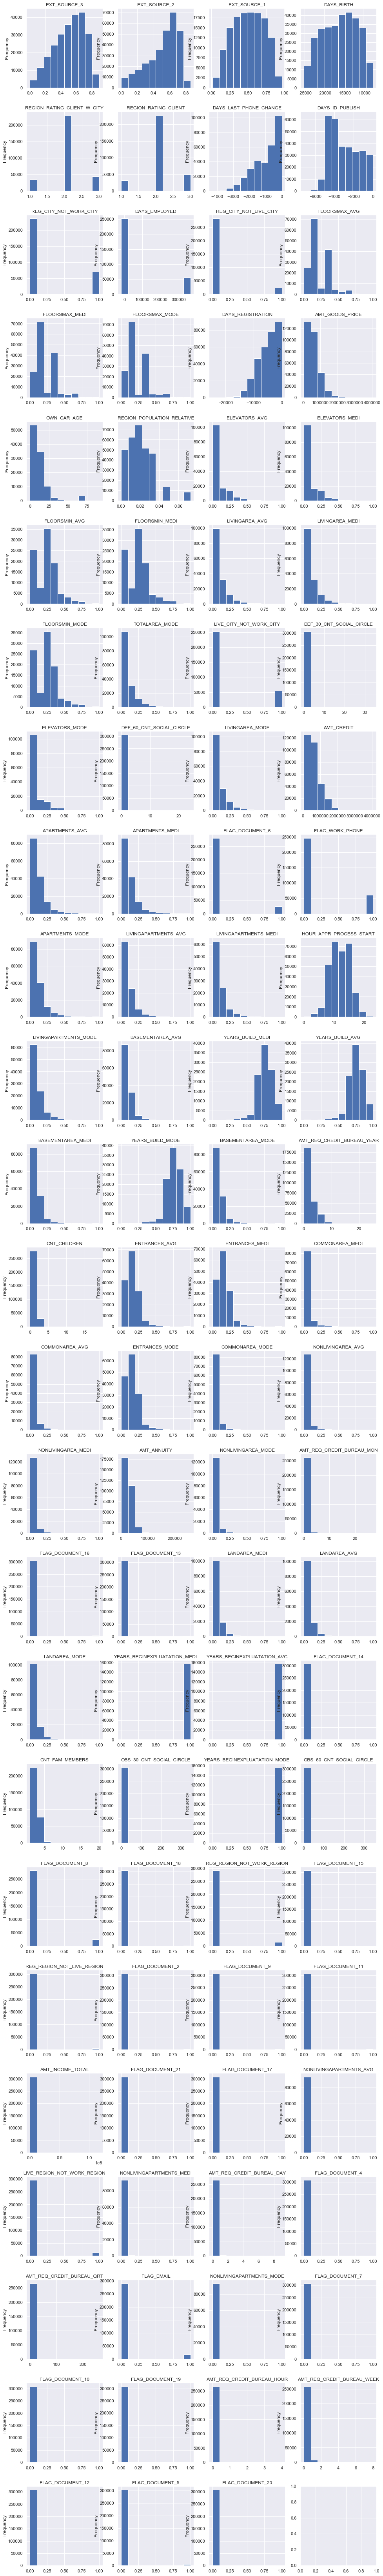

In [9]:
fig, axes = plt.subplots(nrows=25, ncols=4, figsize=(16, 120))
plt.subplots_adjust(hspace=0.3)
axes = axes.flatten()

for i, col in enumerate(corrs.index):
    application_train[col].plot(kind="hist", ax=axes[i])
    axes[i].set_title(col)

Some features are very screwed and range over many orders of magnitude such as `AMT_GOODS_PRICE`, `AMT_CREDIT`, `AMT_ANNUITY`, `AMT_INCOME_TOTAL`. May consider log transforming them.

`DAYS_EMPLOYED` are supposed to be negative but there is a very large positive value.

In [10]:
days_emp_max = application_train["DAYS_EMPLOYED"].max()
print("days_emp_max:", days_emp_max)

print("Count of the maximun value:", sum(application_train["DAYS_EMPLOYED"] == days_emp_max))
print("Count of positive values:", sum(application_train["DAYS_EMPLOYED"] > 0))

default_rate_pos = application_train.loc[application_train["DAYS_EMPLOYED"] == days_emp_max, "TARGET"].mean()
print("Default rate for positive DAYS_EMPLOYED: %0.5f" % default_rate_pos)

default_rate_neg = application_train.loc[application_train["DAYS_EMPLOYED"] < days_emp_max, "TARGET"].mean()
print("Default rate for negative DAYS_EMPLOYED: %0.5f" % default_rate_neg)


days_emp_max: 365243
Count of the maximun value: 55374
Count of positive values: 55374
Default rate for positive DAYS_EMPLOYED: 0.05400
Default rate for negative DAYS_EMPLOYED: 0.08660


The difference is quite significant. So we may consider adding a binary column which indicates whether `DAYS_EMPLOYED` is positive. Also we may change the maximum to 1 or `np.nan`.

## Some engineered features

In [11]:
cols = ["AMT_GOODS_PRICE", "AMT_CREDIT", "AMT_ANNUITY", "AMT_INCOME_TOTAL"]
log_transformed_features = application_train[cols]
for col in cols:
    print(col, (log_transformed_features[col] < 0).any())

for col in cols:
    log_transformed_features[col + "_log"] = np.log(log_transformed_features[col] + 1)

corrs = corrwith(log_transformed_features, application_train["TARGET"])
corrs

AMT_GOODS_PRICE False
AMT_CREDIT False
AMT_ANNUITY False
AMT_INCOME_TOTAL False


feature
AMT_GOODS_PRICE        -0.039645
AMT_CREDIT             -0.030369
AMT_GOODS_PRICE_log    -0.022424
AMT_INCOME_TOTAL_log   -0.018482
AMT_ANNUITY            -0.012817
AMT_CREDIT_log         -0.012181
AMT_INCOME_TOTAL       -0.003982
AMT_ANNUITY_log         0.000779
Name: corr, dtype: float64

It looks like only AMT_INCOME_TOTAL_log improves the correlation. 

In [12]:
credit_to_income = application_train["AMT_CREDIT"] / application_train["AMT_INCOME_TOTAL"]
credit_to_income.corr(application_train["TARGET"])

-0.007726797153464906

In [13]:
# this may be a useful feature
credit_to_goods = application_train["AMT_CREDIT"] / application_train["AMT_GOODS_PRICE"]
credit_to_goods.corr(application_train["TARGET"])

0.06942698687673082

# 2. bureau

In [14]:
bureau = pd.read_csv(os.path.join(INP_DIR, "bureau.csv"))
bureau = change_dtypes(bureau)

print("bureau.shape:", bureau.shape)
bureau.head()

Memory usage before changing types 233.43 MB
Memory usage after changing types 101.27 MB
bureau.shape: (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


## Missing values

In [15]:
missing_vals = bureau.isnull().mean()
missing_vals = missing_vals.sort_values(ascending=False)
print("Total number of features:", bureau.shape[1])
print("Number of features having missing values:", (missing_vals > 0).sum())

print("head:")
display(missing_vals.head(10))

Total number of features: 17
Number of features having missing values: 7
head:


AMT_ANNUITY               0.714735
AMT_CREDIT_MAX_OVERDUE    0.655133
DAYS_ENDDATE_FACT         0.369170
AMT_CREDIT_SUM_LIMIT      0.344774
AMT_CREDIT_SUM_DEBT       0.150119
DAYS_CREDIT_ENDDATE       0.061496
AMT_CREDIT_SUM            0.000008
CREDIT_TYPE               0.000000
AMT_CREDIT_SUM_OVERDUE    0.000000
CNT_CREDIT_PROLONG        0.000000
dtype: float64

## Correlation of aggregated features with `TARGET`

### Numerical features

In [16]:
# aggregate numerical columns with count

bureau_agg = aggregate(bureau.drop(["SK_ID_BUREAU"], axis=1), 
                       by=["SK_ID_CURR"], dtype="num", num_stats=("count",))
print("bureau_agg shape:", bureau_agg.shape)

bureau_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(bureau_agg, how="left", on="SK_ID_CURR")
bureau_agg = bureau_agg.fillna(0)

corrs = corrwith(bureau_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), bureau_agg["TARGET"])
corrs

Drop 5 collinear columns
bureau_agg shape: (305811, 8)


feature
DAYS_ENDDATE_FACT_count        -0.036969
DAYS_CREDIT_ENDDATE_count      -0.016496
DAYS_CREDIT_count              -0.010020
AMT_CREDIT_SUM_LIMIT_count     -0.009552
AMT_ANNUITY_count               0.008354
AMT_CREDIT_SUM_DEBT_count      -0.007407
AMT_CREDIT_MAX_OVERDUE_count   -0.002313
Name: corr, dtype: float64

In [17]:
# aggregate numerical columns with mean

bureau_agg = aggregate(bureau.drop(["SK_ID_BUREAU"], axis=1), 
                       by=["SK_ID_CURR"], dtype="num", num_stats=("mean",))

print("bureau_agg shape:", bureau_agg.shape)

bureau_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(bureau_agg, how="left", on="SK_ID_CURR")

corrs = corrwith(bureau_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), bureau_agg["TARGET"])
corrs

Drop 0 collinear columns
bureau_agg shape: (305811, 13)


feature
DAYS_CREDIT_mean               0.089729
DAYS_CREDIT_UPDATE_mean        0.068927
DAYS_ENDDATE_FACT_mean         0.053200
DAYS_CREDIT_ENDDATE_mean       0.046983
AMT_CREDIT_SUM_mean           -0.019957
AMT_CREDIT_SUM_LIMIT_mean     -0.011446
CREDIT_DAY_OVERDUE_mean        0.008118
AMT_CREDIT_SUM_OVERDUE_mean    0.007150
CNT_CREDIT_PROLONG_mean        0.003031
AMT_CREDIT_MAX_OVERDUE_mean    0.002435
AMT_ANNUITY_mean              -0.001391
AMT_CREDIT_SUM_DEBT_mean      -0.000637
Name: corr, dtype: float64

In [18]:
# aggregate numerical columns with median

bureau_agg = aggregate(bureau.drop(["SK_ID_BUREAU"], axis=1), 
                       by=["SK_ID_CURR"], dtype="num", num_stats=("median",))

print("bureau_agg shape:", bureau_agg.shape)

bureau_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(bureau_agg, how="left", on="SK_ID_CURR")

corrs = corrwith(bureau_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), bureau_agg["TARGET"])
corrs

Drop 0 collinear columns
bureau_agg shape: (305811, 13)


feature
DAYS_CREDIT_median               0.085414
DAYS_CREDIT_UPDATE_median        0.067338
DAYS_ENDDATE_FACT_median         0.050603
DAYS_CREDIT_ENDDATE_median       0.039929
AMT_CREDIT_SUM_median           -0.015676
CREDIT_DAY_OVERDUE_median        0.007847
AMT_CREDIT_SUM_LIMIT_median     -0.006510
AMT_CREDIT_SUM_OVERDUE_median    0.003785
AMT_CREDIT_MAX_OVERDUE_median    0.002251
AMT_ANNUITY_median              -0.002110
AMT_CREDIT_SUM_DEBT_median       0.001666
CNT_CREDIT_PROLONG_median        0.001477
Name: corr, dtype: float64

In [19]:
# aggregate numerical columns with variance

bureau_agg = aggregate(bureau.drop(["SK_ID_BUREAU"], axis=1), 
                       by=["SK_ID_CURR"], dtype="num", num_stats=(np.var,))

print("bureau_agg shape:", bureau_agg.shape)

bureau_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(bureau_agg, how="left", on="SK_ID_CURR")

corrs = corrwith(bureau_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), bureau_agg["TARGET"])
corrs

Drop 0 collinear columns
bureau_agg shape: (305811, 13)


feature
DAYS_CREDIT_var              -0.038440
DAYS_CREDIT_ENDDATE_var       0.037370
DAYS_ENDDATE_FACT_var        -0.017603
AMT_CREDIT_SUM_LIMIT_var     -0.007636
AMT_CREDIT_SUM_DEBT_var      -0.005604
AMT_CREDIT_SUM_OVERDUE_var    0.002222
CREDIT_DAY_OVERDUE_var        0.001516
AMT_CREDIT_SUM_var           -0.001435
AMT_ANNUITY_var               0.001413
DAYS_CREDIT_UPDATE_var        0.001366
AMT_CREDIT_MAX_OVERDUE_var   -0.000870
CNT_CREDIT_PROLONG_var        0.000426
Name: corr, dtype: float64

In [20]:
# aggregate numerical columns with min

bureau_agg = aggregate(bureau.drop(["SK_ID_BUREAU"], axis=1), 
                       by=["SK_ID_CURR"], dtype="num", num_stats=("min",))

print("bureau_agg shape:", bureau_agg.shape)

bureau_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(bureau_agg, how="left", on="SK_ID_CURR")

corrs = corrwith(bureau_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), bureau_agg["TARGET"])
corrs

Drop 0 collinear columns
bureau_agg shape: (305811, 13)


feature
DAYS_CREDIT_min               0.075248
DAYS_ENDDATE_FACT_min         0.055887
DAYS_CREDIT_UPDATE_min        0.042864
DAYS_CREDIT_ENDDATE_min       0.034281
AMT_CREDIT_SUM_min           -0.010764
CREDIT_DAY_OVERDUE_min        0.007573
AMT_CREDIT_SUM_LIMIT_min     -0.004779
AMT_ANNUITY_min              -0.002542
AMT_CREDIT_MAX_OVERDUE_min    0.002329
AMT_CREDIT_SUM_DEBT_min       0.000242
CNT_CREDIT_PROLONG_min       -0.000182
AMT_CREDIT_SUM_OVERDUE_min    0.000003
Name: corr, dtype: float64

In [21]:
# aggregate numerical columns with max

bureau_agg = aggregate(bureau.drop(["SK_ID_BUREAU"], axis=1), 
                       by=["SK_ID_CURR"], dtype="num", num_stats=("max",))

print("bureau_agg shape:", bureau_agg.shape)

bureau_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(bureau_agg, how="left", on="SK_ID_CURR")

corrs = corrwith(bureau_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), bureau_agg["TARGET"])
corrs

Drop 0 collinear columns
bureau_agg shape: (305811, 13)


feature
DAYS_CREDIT_max               0.049782
DAYS_CREDIT_ENDDATE_max       0.036590
DAYS_CREDIT_UPDATE_max        0.028234
AMT_CREDIT_SUM_max           -0.019737
DAYS_ENDDATE_FACT_max         0.019644
AMT_CREDIT_SUM_LIMIT_max     -0.010633
AMT_CREDIT_SUM_OVERDUE_max    0.010614
CREDIT_DAY_OVERDUE_max        0.005493
CNT_CREDIT_PROLONG_max        0.003951
AMT_CREDIT_MAX_OVERDUE_max    0.002540
AMT_CREDIT_SUM_DEBT_max      -0.002173
AMT_ANNUITY_max               0.001120
Name: corr, dtype: float64

### Categorical features

In [22]:
cat_cols = bureau.select_dtypes(["category", "object", "bool"]).columns
for col in cat_cols:
    print(col, bureau[col].nunique())

CREDIT_ACTIVE 4
CREDIT_CURRENCY 4
CREDIT_TYPE 15


In [23]:
# aggregate categorical columns with sum

bureau_agg = aggregate(bureau.drop(["SK_ID_BUREAU"], axis=1), 
                       by=["SK_ID_CURR"], dtype="cat", cat_stats=("sum",))
print("bureau_agg shape:", bureau_agg.shape)

bureau_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(bureau_agg, how="left", on="SK_ID_CURR")
#bureau_agg = bureau_agg.fillna(0)

corrs = corrwith(bureau_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), bureau_agg["TARGET"])
corrs

Drop 0 collinear columns
bureau_agg shape: (305811, 24)


feature
CREDIT_ACTIVE_Active_sum                                        0.067128
CREDIT_TYPE_Credit card_sum                                     0.034818
CREDIT_TYPE_Microloan_sum                                       0.034110
CREDIT_ACTIVE_Closed_sum                                       -0.030812
CREDIT_TYPE_Mortgage_sum                                       -0.023307
CREDIT_TYPE_Car loan_sum                                       -0.020817
CREDIT_ACTIVE_Sold_sum                                          0.012058
CREDIT_TYPE_Consumer credit_sum                                -0.010707
CREDIT_TYPE_Loan for working capital replenishment_sum          0.006018
CREDIT_CURRENCY_currency 2_sum                                 -0.006003
CREDIT_TYPE_Loan for the purchase of equipment_sum              0.004495
CREDIT_CURRENCY_currency 1_sum                                  0.004154
CREDIT_ACTIVE_Bad debt_sum                                      0.004003
CREDIT_TYPE_Loan for business development_s

In [24]:
# aggregate categorical columns with mean

bureau_agg = aggregate(bureau.drop(["SK_ID_BUREAU"], axis=1), 
                       by=["SK_ID_CURR"], dtype="cat", cat_stats=("mean",))
print("bureau_agg shape:", bureau_agg.shape)

bureau_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(bureau_agg, how="left", on="SK_ID_CURR")

corrs = corrwith(bureau_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), bureau_agg["TARGET"])
corrs

Drop 0 collinear columns
bureau_agg shape: (305811, 24)


feature
CREDIT_ACTIVE_Closed_mean                                       -0.079369
CREDIT_ACTIVE_Active_mean                                        0.077356
CREDIT_TYPE_Microloan_mean                                       0.044439
CREDIT_TYPE_Credit card_mean                                     0.034684
CREDIT_TYPE_Consumer credit_mean                                -0.026258
CREDIT_TYPE_Mortgage_mean                                       -0.020867
CREDIT_TYPE_Car loan_mean                                       -0.020134
CREDIT_ACTIVE_Sold_mean                                          0.016530
CREDIT_CURRENCY_currency 2_mean                                 -0.006821
CREDIT_CURRENCY_currency 1_mean                                  0.006037
CREDIT_ACTIVE_Bad debt_mean                                      0.004638
CREDIT_CURRENCY_currency 3_mean                                  0.002783
CREDIT_TYPE_Loan for business development_mean                  -0.002759
CREDIT_TYPE_Unknown type of lo

In [25]:
# aggregate categorical columns with number of unique values

bureau_agg = aggregate(bureau.drop(["SK_ID_BUREAU"], axis=1), 
                       by=["SK_ID_CURR"], dtype="cat", cat_stats=("nunique",), onehot_encode=False)
print("bureau_agg shape:", bureau_agg.shape)

bureau_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(bureau_agg, how="left", on="SK_ID_CURR")
bureau_agg = bureau_agg.fillna(0)

corrs = corrwith(bureau_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), bureau_agg["TARGET"])
corrs

Drop 0 collinear columns
bureau_agg shape: (305811, 4)


feature
CREDIT_CURRENCY_nunique   -0.031060
CREDIT_ACTIVE_nunique     -0.025051
CREDIT_TYPE_nunique       -0.019160
Name: corr, dtype: float64

In [26]:
# aggregate categorical columns with mode

bureau_agg = aggregate(bureau.drop(["SK_ID_BUREAU"], axis=1), 
                       by=["SK_ID_CURR"], dtype="cat", cat_stats=(mode,), onehot_encode=False)
print("bureau_agg shape:", bureau_agg.shape)
bureau_agg.head()

Drop 0 collinear columns
bureau_agg shape: (305811, 4)


,SK_ID_CURR,CREDIT_ACTIVE_mode,CREDIT_CURRENCY_mode,CREDIT_TYPE_mode
0,100001,Closed,currency 1,Consumer credit
1,100002,Closed,currency 1,Consumer credit
2,100003,Closed,currency 1,Consumer credit
3,100004,Closed,currency 1,Consumer credit
4,100005,Active,currency 1,Consumer credit


### Engineered features

#### Count and percent of number of times DPD are over 1, 3, and 6 months

In [27]:
# agg by mean

credit_day_overdue = bureau[["SK_ID_CURR"]]
credit_day_overdue["CREDIT_DAY_OVERDUE_OVER_0M"] = bureau["CREDIT_DAY_OVERDUE"] == 0
credit_day_overdue["CREDIT_DAY_OVERDUE_OVER_1M"] = bureau["CREDIT_DAY_OVERDUE"] > 30
credit_day_overdue["CREDIT_DAY_OVERDUE_OVER_3M"] = bureau["CREDIT_DAY_OVERDUE"] > 90
credit_day_overdue["CREDIT_DAY_OVERDUE_OVER_6M"] = bureau["CREDIT_DAY_OVERDUE"] > 120

credit_day_overdue_agg = aggregate(credit_day_overdue, by=["SK_ID_CURR"], dtype="cat", cat_stats=("mean",))
print("credit_day_overdue_agg shape:", credit_day_overdue_agg.shape)

credit_day_overdue_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(credit_day_overdue_agg, 
                                                                           how="left", on="SK_ID_CURR")

corrs = corrwith(credit_day_overdue_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), credit_day_overdue_agg["TARGET"])
corrs

Drop 0 collinear columns
credit_day_overdue_agg shape: (305811, 5)


feature
CREDIT_DAY_OVERDUE_OVER_0M_mean   -0.031932
CREDIT_DAY_OVERDUE_OVER_1M_mean    0.020789
CREDIT_DAY_OVERDUE_OVER_3M_mean    0.013065
CREDIT_DAY_OVERDUE_OVER_6M_mean    0.012058
Name: corr, dtype: float64

In [28]:
# agg by sum

credit_day_overdue_agg = aggregate(credit_day_overdue, by=["SK_ID_CURR"], dtype="cat", cat_stats=("sum",))
print("credit_day_overdue_agg shape:", credit_day_overdue_agg.shape)

credit_day_overdue_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(credit_day_overdue_agg, 
                                                                           how="left", on="SK_ID_CURR")
credit_day_overdue_agg = credit_day_overdue_agg.fillna(0)
corrs = corrwith(credit_day_overdue_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), credit_day_overdue_agg["TARGET"])
corrs

Drop 0 collinear columns
credit_day_overdue_agg shape: (305811, 5)


feature
CREDIT_DAY_OVERDUE_OVER_1M_sum    0.021439
CREDIT_DAY_OVERDUE_OVER_0M_sum   -0.011034
CREDIT_DAY_OVERDUE_OVER_3M_sum    0.009345
CREDIT_DAY_OVERDUE_OVER_6M_sum    0.007664
Name: corr, dtype: float64

#### Whether `DAYS_CREDIT_ENDDATE` is positive

In [29]:
# agg by mean

days_credit_enddate_pos = bureau[["SK_ID_CURR"]]
days_credit_enddate_pos["DAYS_CREDIT_ENDDATE_POS"] = bureau["DAYS_CREDIT_ENDDATE"] > 0

days_credit_enddate_pos_agg = aggregate(days_credit_enddate_pos, by=["SK_ID_CURR"], dtype="cat", cat_stats=("mean",))

print("days_credit_enddate_pos_agg shape:", days_credit_enddate_pos_agg.shape)

days_credit_enddate_pos_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(days_credit_enddate_pos_agg, 
                                                                           how="left", on="SK_ID_CURR")

corrs = corrwith(days_credit_enddate_pos_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), 
                 days_credit_enddate_pos_agg["TARGET"])
corrs

Drop 0 collinear columns
days_credit_enddate_pos_agg shape: (305811, 2)


feature
DAYS_CREDIT_ENDDATE_POS_mean    0.055305
Name: corr, dtype: float64

In [30]:
# agg by sum
days_credit_enddate_pos_agg = aggregate(days_credit_enddate_pos, by=["SK_ID_CURR"], dtype="cat", cat_stats=("sum",))

print("days_credit_enddate_pos_agg shape:", days_credit_enddate_pos_agg.shape)

days_credit_enddate_pos_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(days_credit_enddate_pos_agg, 
                                                                           how="left", on="SK_ID_CURR")
days_credit_enddate_pos_agg = days_credit_enddate_pos_agg.fillna(0)

corrs = corrwith(days_credit_enddate_pos_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), 
                 days_credit_enddate_pos_agg["TARGET"])
corrs

Drop 0 collinear columns
days_credit_enddate_pos_agg shape: (305811, 2)


feature
DAYS_CREDIT_ENDDATE_POS_sum    0.032456
Name: corr, dtype: float64

#### Whether `DAYS_CREDIT_UPDATE` is positive

In [31]:
# very few cases 
(bureau["DAYS_CREDIT_UPDATE"] > 0).sum()

17

### Debt to Credit ratio and Total overdue to debt ratio

In [33]:
amt_agg = aggregate(bureau[["SK_ID_CURR", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_OVERDUE"]],
                   by=["SK_ID_CURR"], dtype="num", num_stats=("sum",))

amt_agg["DEBT_TO_CREDIT"] = amt_agg["AMT_CREDIT_SUM_DEBT_sum"] / amt_agg["AMT_CREDIT_SUM_sum"]
amt_agg["OVERDUE_TO_DEBT"] = amt_agg["AMT_CREDIT_SUM_OVERDUE_sum"] / amt_agg["AMT_CREDIT_SUM_DEBT_sum"]

amt_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(amt_agg, how="left", on="SK_ID_CURR")

amt_agg["DEBT_TO_CREDIT"] = amt_agg["DEBT_TO_CREDIT"].replace({np.inf: np.nan, -np.inf: np.nan})

amt_agg["OVERDUE_TO_DEBT"] = amt_agg["OVERDUE_TO_DEBT"].replace({np.inf: np.nan, -np.inf: np.nan})

corrs = corrwith(amt_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), amt_agg["TARGET"])
corrs

Drop 0 collinear columns


feature
DEBT_TO_CREDIT                0.060235
AMT_CREDIT_SUM_sum           -0.014057
AMT_CREDIT_SUM_OVERDUE_sum    0.013335
AMT_CREDIT_SUM_DEBT_sum       0.007144
OVERDUE_TO_DEBT               0.000939
Name: corr, dtype: float64

#### Time between successive loans

In [38]:
time_bet_loans = aggregate(bureau[["SK_ID_CURR", "DAYS_CREDIT"]], by=["SK_ID_CURR"], dtype="num",
                           num_stats=(mean_diff, var_diff, range_diff,))
time_bet_loans = application_train[["SK_ID_CURR", "TARGET"]].merge(time_bet_loans, how="left", on="SK_ID_CURR")

Drop 0 collinear columns


In [39]:
for col in time_bet_loans.columns:
    time_bet_loans[col] = time_bet_loans[col].replace({np.inf: np.nan, -np.inf: np.nan})
    
corrs = corrwith(time_bet_loans.drop(["SK_ID_CURR", "TARGET"], axis=1), time_bet_loans["TARGET"])
corrs

feature
DAYS_CREDIT_mean_diff    -0.035060
DAYS_CREDIT_range_diff   -0.025896
DAYS_CREDIT_var_diff     -0.014703
Name: corr, dtype: float64

# 3. `bureau_balance`

In [40]:
bureau_balance = pd.read_csv(os.path.join(INP_DIR, "bureau_balance.csv"))
bureau_balance = change_dtypes(bureau_balance)

print("bureau_balance.shape:", bureau_balance.shape)
bureau_balance.head()

Memory usage before changing types 655.20 MB
Memory usage after changing types 245.70 MB
bureau_balance.shape: (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [41]:
print("MONTHS_BALANCE min:", bureau_balance["MONTHS_BALANCE"].min())
print("MONTHS_BALANCE max:", bureau_balance["MONTHS_BALANCE"].max())

print("STATUS unique values:", bureau_balance["STATUS"].unique())

MONTHS_BALANCE min: -96
MONTHS_BALANCE max: 0
STATUS unique values: [C, 0, X, 1, 2, 3, 5, 4]
Categories (8, object): [C, 0, X, 1, 2, 3, 5, 4]


## Missing values

In [42]:
missing_vals = bureau_balance.isnull().mean()
missing_vals = missing_vals.sort_values(ascending=False)
print("Total number of features:", bureau_balance.shape[1])
print("Number of features having missing values:", (missing_vals > 0).sum())

print("head:")
display(missing_vals.head(10))

Total number of features: 3
Number of features having missing values: 0
head:


STATUS            0.0
MONTHS_BALANCE    0.0
SK_ID_BUREAU      0.0
dtype: float64

## Aggregate once

In [43]:
bureau_balance_merge = application_train[["SK_ID_CURR"]].merge(bureau[["SK_ID_CURR", "SK_ID_BUREAU"]], 
                                                                      how="left", on="SK_ID_CURR")

bureau_balance_merge = bureau_balance_merge.merge(bureau_balance, how="left", on="SK_ID_BUREAU")
bureau_balance_merge = bureau_balance_merge.drop(["SK_ID_BUREAU"], axis=1)

bureau_balance_agg = aggregate(bureau_balance_merge, by=["SK_ID_CURR"], 
                               num_stats=("count", "mean", "min", "max", np.var),
                              cat_stats=("sum", "mean"))

bureau_balance_agg_uniq = aggregate(bureau_balance_merge, by=["SK_ID_CURR"], dtype="cat", 
                                    cat_stats=("nunique",))

bureau_balance_agg = bureau_balance_agg.merge(bureau_balance_agg_uniq, how="outer", on="SK_ID_CURR")

print("bureau_balance_agg shape:", bureau_balance_agg.shape)

bureau_balance_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(bureau_balance_agg, 
                                                                       how="left", on="SK_ID_CURR")

corrs = corrwith(bureau_balance_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), bureau_balance_agg["TARGET"])
corrs

Drop 0 collinear columns
Drop 0 collinear columns
bureau_balance_agg shape: (307511, 30)


feature
MONTHS_BALANCE_mean     0.074416
MONTHS_BALANCE_min      0.073225
MONTHS_BALANCE_var     -0.051335
STATUS_1_mean           0.033021
STATUS_1_nunique        0.023553
STATUS_C_sum           -0.021756
STATUS_C_mean          -0.017915
MONTHS_BALANCE_count   -0.017482
STATUS_0_mean           0.016825
STATUS_1_sum            0.013991
STATUS_2_mean           0.011150
STATUS_X_sum           -0.011022
STATUS_5_mean           0.010525
STATUS_3_mean           0.010089
STATUS_4_nunique        0.010085
STATUS_4_mean           0.009940
STATUS_C_nunique       -0.009337
STATUS_5_nunique        0.009054
STATUS_3_nunique        0.008935
STATUS_4_sum            0.008585
STATUS_2_nunique        0.008455
STATUS_3_sum            0.007912
STATUS_2_sum            0.007755
STATUS_0_sum           -0.007233
STATUS_5_sum            0.005691
MONTHS_BALANCE_max      0.005119
STATUS_X_nunique        0.002118
STATUS_0_nunique        0.000558
STATUS_X_mean           0.000528
Name: corr, dtype: float64

## Aggregate stepwise

In [45]:
bureau_balance_agg = aggregate(bureau_balance, by=["SK_ID_BUREAU"], 
                               num_stats=("count", "mean", "min", "max", np.var),
                               cat_stats=("sum", "mean"))

bureau_balance_agg_uniq = aggregate(bureau_balance, by=["SK_ID_BUREAU"], dtype="cat",
                                    cat_stats=("nunique",), onehot_encode=False)

bureau_balance_agg = bureau_balance_agg.merge(bureau_balance_agg_uniq, how="outer", on="SK_ID_BUREAU")

bureau_balance_agg = bureau[["SK_ID_CURR", "SK_ID_BUREAU"]].merge(bureau_balance_agg, how="left", on="SK_ID_BUREAU")

bureau_balance_agg = bureau_balance_agg.drop(["SK_ID_BUREAU"], axis=1)

bureau_balance_agg = aggregate(bureau_balance_agg, by=["SK_ID_CURR"], 
                              num_stats=("count", "mean", "min", "max", np.var), dtype="num")

print("bureau_balance_agg shape:", bureau_balance_agg.shape)

bureau_balance_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(bureau_balance_agg, 
                                                                       how="left", on="SK_ID_CURR")

corrs = corrwith(bureau_balance_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), bureau_balance_agg["TARGET"])
corrs

Drop 0 collinear columns
Drop 0 collinear columns
Drop 20 collinear columns
bureau_balance_agg shape: (305811, 91)


feature
MONTHS_BALANCE_min_mean       0.089038
MONTHS_BALANCE_count_mean    -0.080193
MONTHS_BALANCE_mean_mean      0.076424
MONTHS_BALANCE_min_min        0.073225
MONTHS_BALANCE_count_max     -0.068792
MONTHS_BALANCE_var_mean      -0.062957
STATUS_C_sum_mean            -0.062954
STATUS_1_mean_mean            0.061183
STATUS_1_mean_max             0.061122
STATUS_C_sum_max             -0.061083
MONTHS_BALANCE_var_max       -0.059855
STATUS_C_mean_mean           -0.055936
MONTHS_BALANCE_mean_min       0.053816
MONTHS_BALANCE_min_max        0.049807
MONTHS_BALANCE_count_min     -0.048224
STATUS_C_sum_var             -0.046157
STATUS_0_mean_mean            0.044198
STATUS_C_mean_max            -0.044119
MONTHS_BALANCE_mean_max       0.043956
MONTHS_BALANCE_var_var       -0.040304
MONTHS_BALANCE_count_var     -0.037909
STATUS_1_mean_var             0.037443
STATUS_1_mean_min             0.037332
STATUS_0_sum_mean            -0.035868
MONTHS_BALANCE_min_var       -0.035045
STATUS_X_sum_mean

# 4. `previous_application`

In [46]:
previous_application = pd.read_csv(os.path.join(INP_DIR, "previous_application.csv"))
previous_application = change_dtypes(previous_application)

print("previous_application shape:", previous_application.shape)
previous_application.head()

Memory usage before changing types 494.38 MB
Memory usage after changing types 162.02 MB
previous_application shape: (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## Missing values
`RATE_INTEREST_PRIVILEGED` and `RATE_INTEREST_PRIMARY` have more than 99% missing values. We can drop these two columns.

In [47]:
missing_vals = previous_application.isnull().mean()
missing_vals = missing_vals.sort_values(ascending=False)
print("Total number of features:", previous_application.shape[1])
print("Number of features having missing values:", (missing_vals > 0).sum())

print("head:")
display(missing_vals.head(20))

previous_application = previous_application.drop(["RATE_INTEREST_PRIVILEGED", "RATE_INTEREST_PRIMARY"], axis=1)

Total number of features: 37
Number of features having missing values: 16
head:


RATE_INTEREST_PRIVILEGED      9.964370e-01
RATE_INTEREST_PRIMARY         9.964370e-01
RATE_DOWN_PAYMENT             5.363648e-01
AMT_DOWN_PAYMENT              5.363648e-01
NAME_TYPE_SUITE               4.911975e-01
DAYS_TERMINATION              4.029813e-01
NFLAG_INSURED_ON_APPROVAL     4.029813e-01
DAYS_FIRST_DRAWING            4.029813e-01
DAYS_FIRST_DUE                4.029813e-01
DAYS_LAST_DUE_1ST_VERSION     4.029813e-01
DAYS_LAST_DUE                 4.029813e-01
AMT_GOODS_PRICE               2.308177e-01
AMT_ANNUITY                   2.228667e-01
CNT_PAYMENT                   2.228637e-01
PRODUCT_COMBINATION           2.071591e-04
AMT_CREDIT                    5.987257e-07
SK_ID_CURR                    0.000000e+00
NAME_CONTRACT_TYPE            0.000000e+00
WEEKDAY_APPR_PROCESS_START    0.000000e+00
HOUR_APPR_PROCESS_START       0.000000e+00
dtype: float64

`RATE_INTEREST_PRIVILEGED` and `RATE_INTEREST_PRIMARY` have more than 99% missing values. We can drop these two columns.

## Aggregate numerical columns

In [48]:
# agg by count
previous_application_agg = aggregate(previous_application.drop(["SK_ID_PREV"], axis=1), 
                                     by=["SK_ID_CURR"], dtype="num",
                                     num_stats=("count",))

print("previous_application_agg shape:", previous_application_agg.shape)

previous_application_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(previous_application_agg, 
                                                                       how="left", on="SK_ID_CURR")

corrs = corrwith(previous_application_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), previous_application_agg["TARGET"])
corrs

Drop 11 collinear columns
previous_application_agg shape: (338857, 6)


feature
DAYS_FIRST_DRAWING_count   -0.031833
AMT_DOWN_PAYMENT_count     -0.023725
AMT_APPLICATION_count       0.019762
AMT_GOODS_PRICE_count       0.008726
AMT_ANNUITY_count           0.007338
Name: corr, dtype: float64

In [49]:
# agg by mean
previous_application_agg = aggregate(previous_application.drop(["SK_ID_PREV"], axis=1), 
                                     by=["SK_ID_CURR"], dtype="num",
                                     num_stats=("mean",))

print("previous_application_agg shape:", previous_application_agg.shape)

previous_application_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(previous_application_agg, 
                                                                       how="left", on="SK_ID_CURR")

corrs = corrwith(previous_application_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), previous_application_agg["TARGET"])
corrs

Drop 0 collinear columns
previous_application_agg shape: (338857, 17)


feature
DAYS_FIRST_DRAWING_mean          -0.048803
DAYS_DECISION_mean                0.046864
HOUR_APPR_PROCESS_START_mean     -0.035927
AMT_ANNUITY_mean                 -0.034871
RATE_DOWN_PAYMENT_mean           -0.033601
DAYS_LAST_DUE_1ST_VERSION_mean    0.031203
CNT_PAYMENT_mean                  0.027743
DAYS_LAST_DUE_mean                0.026923
DAYS_TERMINATION_mean             0.025795
AMT_DOWN_PAYMENT_mean            -0.024624
AMT_APPLICATION_mean             -0.021803
AMT_CREDIT_mean                  -0.016114
AMT_GOODS_PRICE_mean             -0.015847
DAYS_FIRST_DUE_mean              -0.009334
SELLERPLACE_AREA_mean            -0.002433
NFLAG_INSURED_ON_APPROVAL_mean   -0.000527
Name: corr, dtype: float64

In [50]:
# agg by min
previous_application_agg = aggregate(previous_application.drop(["SK_ID_PREV"], axis=1), 
                                     by=["SK_ID_CURR"], dtype="num",
                                     num_stats=("min",))

print("previous_application_agg shape:", previous_application_agg.shape)

previous_application_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(previous_application_agg, 
                                                                       how="left", on="SK_ID_CURR")

corrs = corrwith(previous_application_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), previous_application_agg["TARGET"])
corrs

Drop 0 collinear columns
previous_application_agg shape: (338857, 17)


feature
DAYS_DECISION_min                0.053434
DAYS_FIRST_DRAWING_min          -0.044643
AMT_ANNUITY_min                 -0.032249
HOUR_APPR_PROCESS_START_min     -0.031427
DAYS_LAST_DUE_min                0.026186
DAYS_TERMINATION_min             0.025605
AMT_APPLICATION_min             -0.020828
AMT_GOODS_PRICE_min             -0.020811
AMT_CREDIT_min                  -0.019417
AMT_DOWN_PAYMENT_min            -0.016950
RATE_DOWN_PAYMENT_min           -0.014784
DAYS_LAST_DUE_1ST_VERSION_min    0.014645
NFLAG_INSURED_ON_APPROVAL_min    0.011687
CNT_PAYMENT_min                 -0.010789
DAYS_FIRST_DUE_min               0.006042
SELLERPLACE_AREA_min            -0.001294
Name: corr, dtype: float64

In [51]:
# agg by max
previous_application_agg = aggregate(previous_application.drop(["SK_ID_PREV"], axis=1), 
                                     by=["SK_ID_CURR"], dtype="num",
                                     num_stats=("max",))

print("previous_application_agg shape:", previous_application_agg.shape)

previous_application_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(previous_application_agg, 
                                                                       how="left", on="SK_ID_CURR")

corrs = corrwith(previous_application_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), previous_application_agg["TARGET"])
corrs

Drop 1 collinear columns
previous_application_agg shape: (338857, 16)


feature
RATE_DOWN_PAYMENT_max           -0.040096
HOUR_APPR_PROCESS_START_max     -0.030847
CNT_PAYMENT_max                  0.029439
AMT_ANNUITY_max                 -0.028966
AMT_DOWN_PAYMENT_max            -0.025290
DAYS_FIRST_DUE_max              -0.020158
DAYS_LAST_DUE_1ST_VERSION_max    0.019065
DAYS_DECISION_max                0.016399
DAYS_FIRST_DRAWING_max          -0.015053
AMT_APPLICATION_max             -0.012605
NFLAG_INSURED_ON_APPROVAL_max   -0.010710
AMT_CREDIT_max                  -0.008439
DAYS_LAST_DUE_max                0.006689
DAYS_TERMINATION_max             0.005217
SELLERPLACE_AREA_max            -0.003135
Name: corr, dtype: float64

In [52]:
# agg by var
previous_application_agg = aggregate(previous_application.drop(["SK_ID_PREV"], axis=1), 
                                     by=["SK_ID_CURR"], dtype="num",
                                     num_stats=(np.var,))

print("previous_application_agg shape:", previous_application_agg.shape)

previous_application_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(previous_application_agg, 
                                                                       how="left", on="SK_ID_CURR")

corrs = corrwith(previous_application_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), previous_application_agg["TARGET"])
corrs

Drop 0 collinear columns
previous_application_agg shape: (338857, 17)


feature
DAYS_FIRST_DRAWING_var           0.069076
DAYS_DECISION_var               -0.048513
DAYS_LAST_DUE_1ST_VERSION_var    0.046016
CNT_PAYMENT_var                  0.041960
DAYS_LAST_DUE_var                0.023003
RATE_DOWN_PAYMENT_var           -0.022597
DAYS_TERMINATION_var             0.022133
AMT_ANNUITY_var                 -0.020936
AMT_APPLICATION_var             -0.014470
AMT_GOODS_PRICE_var             -0.014287
AMT_CREDIT_var                  -0.012527
DAYS_FIRST_DUE_var              -0.008614
HOUR_APPR_PROCESS_START_var     -0.007854
NFLAG_INSURED_ON_APPROVAL_var    0.007793
AMT_DOWN_PAYMENT_var             0.002022
SELLERPLACE_AREA_var            -0.001046
Name: corr, dtype: float64

## Aggregate categorical columns

In [53]:
cat_cols = previous_application.select_dtypes(["category", "object", "bool"]).columns
for col in cat_cols:
    print(col, previous_application[col].nunique())

cat_cols_1 = [col for col in cat_cols if previous_application[col].nunique() <= 5]
cat_cols_2 = [col for col in cat_cols if previous_application[col].nunique() > 5]

print("cat_cols_1", cat_cols_1)
print("cat_cols_2", cat_cols_2)

NAME_CONTRACT_TYPE 4
WEEKDAY_APPR_PROCESS_START 7
FLAG_LAST_APPL_PER_CONTRACT 2
NFLAG_LAST_APPL_IN_DAY 2
NAME_CASH_LOAN_PURPOSE 25
NAME_CONTRACT_STATUS 4
NAME_PAYMENT_TYPE 4
CODE_REJECT_REASON 9
NAME_TYPE_SUITE 7
NAME_CLIENT_TYPE 4
NAME_GOODS_CATEGORY 28
NAME_PORTFOLIO 5
NAME_PRODUCT_TYPE 3
CHANNEL_TYPE 8
NAME_SELLER_INDUSTRY 11
NAME_YIELD_GROUP 5
PRODUCT_COMBINATION 17
cat_cols_1 ['NAME_CONTRACT_TYPE', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'NAME_YIELD_GROUP']
cat_cols_2 ['WEEKDAY_APPR_PROCESS_START', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_GOODS_CATEGORY', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION']


In [54]:
# only categorical columns having nunique less than or equal to 5
# agg by sum and mean
previous_application_agg = aggregate(previous_application.drop(cat_cols_2, axis=1), 
                                     by=["SK_ID_CURR"], dtype="cat", cat_stats=("sum", "mean"))


print("previous_application_agg shape:", previous_application_agg.shape)

previous_application_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(previous_application_agg, 
                                                                       how="left", on="SK_ID_CURR")

corrs = corrwith(previous_application_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), previous_application_agg["TARGET"])
corrs

Drop 1 collinear columns
previous_application_agg shape: (338857, 64)


feature
NAME_CONTRACT_STATUS_Refused_mean                                   0.077671
NAME_CONTRACT_STATUS_Refused_sum                                    0.064469
NAME_CONTRACT_STATUS_Approved_mean                                 -0.063521
NAME_PRODUCT_TYPE_walk-in_sum                                       0.062628
NAME_PRODUCT_TYPE_walk-in_mean                                      0.057412
NAME_CLIENT_TYPE_New_sum                                            0.046048
NAME_CONTRACT_TYPE_Revolving loans_sum                              0.045602
NAME_YIELD_GROUP_XNA_mean                                           0.042848
NAME_YIELD_GROUP_XNA_sum                                            0.041713
NAME_PORTFOLIO_Cards_sum                                            0.041480
NAME_YIELD_GROUP_low_normal_mean                                   -0.041134
NAME_PAYMENT_TYPE_XNA_sum                                           0.039469
NAME_CONTRACT_TYPE_Revolving loans_mean                             

In [55]:
# only categorical columns having nunique less than or equal to 5
# agg by nunique
previous_application_agg = aggregate(previous_application.drop(cat_cols_2, axis=1), 
                                     by=["SK_ID_CURR"], dtype="cat", cat_stats=("nunique",), onehot_encode=False)

print("previous_application_agg shape:", previous_application_agg.shape)

previous_application_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(previous_application_agg, 
                                                                       how="left", on="SK_ID_CURR")

corrs = corrwith(previous_application_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), previous_application_agg["TARGET"])
corrs

Drop 0 collinear columns
previous_application_agg shape: (338857, 10)


feature
NAME_CONTRACT_STATUS_nunique           0.041087
NAME_PRODUCT_TYPE_nunique              0.028378
NAME_PORTFOLIO_nunique                 0.026665
NAME_CONTRACT_TYPE_nunique             0.024550
NAME_PAYMENT_TYPE_nunique              0.014845
NAME_YIELD_GROUP_nunique              -0.007635
FLAG_LAST_APPL_PER_CONTRACT_nunique    0.006982
NFLAG_LAST_APPL_IN_DAY_nunique         0.004685
NAME_CLIENT_TYPE_nunique               0.001022
Name: corr, dtype: float64

In [56]:
# only categorical columns having nunique less than or equal to 5
# agg by sum and mean
previous_application_agg = aggregate(previous_application.drop(cat_cols_1, axis=1), 
                                     by=["SK_ID_CURR"], dtype="cat", cat_stats=("sum", "mean"))


print("previous_application_agg shape:", previous_application_agg.shape)

previous_application_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(previous_application_agg, 
                                                                       how="left", on="SK_ID_CURR")

corrs = corrwith(previous_application_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), previous_application_agg["TARGET"])
corrs

Drop 2 collinear columns
previous_application_agg shape: (338857, 223)


feature
CODE_REJECT_REASON_XAP_mean                            -0.073930
CODE_REJECT_REASON_SCOFR_sum                            0.056284
CODE_REJECT_REASON_SCOFR_mean                           0.055865
CODE_REJECT_REASON_HC_mean                              0.054531
PRODUCT_COMBINATION_Card Street_sum                     0.047953
CODE_REJECT_REASON_HC_sum                               0.047067
CODE_REJECT_REASON_LIMIT_sum                            0.040503
PRODUCT_COMBINATION_Card Street_mean                    0.040242
CODE_REJECT_REASON_LIMIT_mean                           0.039842
PRODUCT_COMBINATION_Cash X-Sell: low_mean              -0.037494
PRODUCT_COMBINATION_Cash X-Sell: high_sum               0.036291
CHANNEL_TYPE_AP+ (Cash loan)_mean                       0.034828
CHANNEL_TYPE_AP+ (Cash loan)_sum                        0.034715
PRODUCT_COMBINATION_POS industry with interest_mean    -0.033942
NAME_GOODS_CATEGORY_XNA_sum                             0.032688
NAME_GOODS_CATEGO

In [57]:
# only categorical columns having nunique less than or equal to 5
# agg by nunique
previous_application_agg = aggregate(previous_application.drop(cat_cols_1, axis=1), 
                                     by=["SK_ID_CURR"], dtype="cat", cat_stats=("nunique",), onehot_encode=False)

print("previous_application_agg shape:", previous_application_agg.shape)

previous_application_agg = application_train[["SK_ID_CURR", "TARGET"]].merge(previous_application_agg, 
                                                                       how="left", on="SK_ID_CURR")

corrs = corrwith(previous_application_agg.drop(["SK_ID_CURR", "TARGET"], axis=1), previous_application_agg["TARGET"])
corrs

Drop 0 collinear columns
previous_application_agg shape: (338857, 9)


feature
CODE_REJECT_REASON_nunique            0.063640
NAME_CASH_LOAN_PURPOSE_nunique        0.036255
NAME_GOODS_CATEGORY_nunique          -0.022185
NAME_TYPE_SUITE_nunique              -0.022025
NAME_SELLER_INDUSTRY_nunique         -0.014802
PRODUCT_COMBINATION_nunique           0.008857
CHANNEL_TYPE_nunique                  0.001700
WEEKDAY_APPR_PROCESS_START_nunique    0.001208
Name: corr, dtype: float64

We will similarly aggregate `POS_CASH_balance`, `credit_card_balance` and `installments_payments` tables.